In [1]:
using Plots
using Serialization
using Random

In [2]:
const Nx = 1000
const Dx = 0.01
Lx = Nx * Dx
const Dt = 0.00005
const skiptime = 1000
const digits = 3
const Cd = 1.0

1.0

In [3]:
# 初期値
prefix = "230116_2-1"
u0 = quote
    # 0.005 * (rand(MersenneTwister(123), Float64, Nx + 1))[Int(round(x / Dx + 1))]
    # 0.005*rand(MersenneTwister(123), Float64, Nx+1)[Int(round(x/Dx+1))]-0.005
    # 0.005*rand(MersenneTwister(123), Float64, Nx+1)[Int(round(x/Dx+1))]-0.005-0.6
    0.5 * cos(2*pi*x/Lx) + 0.5
    #0.1 * sin(5*pi*x/(Lx+Dx))
    # 0.005 * cos(pi*x/Lx)
    # -0.005 * cos(3*pi*x/Lx)
    # 0.1 * cos(3*pi*x/(Lx+Dx)) - 0.1
end
datapath = "../data/N-c_fE/"*prefix
initialtime = 0.0
timespan = 1000000

tag = 1

1

In [4]:
# 解析の準備
if !isdir(datapath)
    mkdir(datapath)
    mkdir(datapath*"/fig")
    mkdir(datapath*"/graph")
    mkdir(datapath*"/anim")
    mkdir(datapath*"/var")
    mkdir(datapath*"/u")
end

data = Dict()
data["Lx"] = Lx
data["Nx"] = Nx
data["Dx"] = Dx
data["Dt"] = Dt
data["skiptime"] = skiptime
data["digits"] = digits
data["Cd"] = Cd
data["u0"] = u0
serialize(datapath*"/params.dat", data)

open(datapath*"/params.txt", "w") do f
    println(f,"Lx,$(Lx)")
    println(f,"Nx,$(Nx)")
    println(f,"Dx,$(Dx)")
    println(f,"Dt,$(Dt)")
    println(f,"Cd,$(Cd)")
    println(f,"u0,$(u0)")
end

# 初期値の設定
u = zeros(Nx+3)
@inbounds for k in 2:Nx+2
    global x = (k-2)*Dx
    u[k] = eval(u0)
end
u[1] = u[3]         # central
u[Nx+3] = u[Nx+1]   # central

open(datapath*"/initialdata.txt", "w") do f
    print(f,string(u0))
end

# 保存
up = u[2:Nx+2]
xtmp = 0.0:Dx:Lx
plot(xtmp, up, title="initial data", label="")
savefig(datapath*"/fig/initial_u.png")

time = 0.0
time = round(time, digits=digits)
u_data = Dict()
u_data["u"] = u
serialize(datapath*"/u/"*string(time)*".dat", u_data)

In [5]:
function result_out(u1, time; datapath, Nx, Dx, digits)
    """ 計算結果と関連する値の出力 """
    time = round(time, digits=digits)
    u1_data = Dict()
    u1_data["u"] = u1
    serialize(datapath*"/u/"*string(time)*".dat", u1_data)
end

function scheme(u1; Nx, Dx, Dt, Cd)
    u2 = similar(u1)
    for k in 3:Nx+1
        u2[k] = u1[k] + Dt/Dx/Dx*Cd*(u1[k+1]-2*u1[k]+u1[k-1])
    end
    u2[2] = u1[2] + Dt/Dx/Dx*Cd*2*(u1[3]-u1[2])
    u2[Nx+2] = u1[Nx+2] + Dt/Dx/Dx*Cd*2*(u1[Nx+1]-u1[Nx+2])
    u2[1] = u2[3]
    u2[Nx+3] = u2[Nx+1]
    
    return u2
end

function calc(initialtime, timespan; datapath, Dt, skiptime, scheme, result_out)
    u_data = deserialize(datapath*"/u/"*string(initialtime)*".dat")
    u1 = u_data["u"]
    u2 = similar(u1)
    ### 時間発展
    @inbounds for loop = 1:timespan
        u2 = scheme(u1)
        # 毎回出力するとデータが多すぎるので、skip_time ステップごとに出力する．
        if mod(loop, skiptime) == 0
            result_out(u2, initialtime+loop*Dt)
        end
        # u と up の中身交換(正確にはポインタを交換してるだけ)
        u1, u2 = u2, u1
    end
end

calc (generic function with 1 method)

In [6]:
u_tmp = zeros(Nx+3)
time_tmp = 0.0
result_out_fix(u_tmp, time_tmp) = result_out(u_tmp, time_tmp; datapath=datapath, Nx=Nx, Dx=Dx, digits=digits)
scheme_fix(u_tmp) = scheme(u_tmp; Nx=Nx, Dx=Dx, Dt=Dt, Cd=Cd)

scheme_fix (generic function with 1 method)

In [7]:
result_out_fix(u, 0.0)
s = @elapsed begin
    calc(initialtime, timespan; datapath=datapath, Dt=Dt, skiptime=skiptime, scheme=scheme_fix, result_out=result_out_fix)
end
println("Program ended.")
println("# elapsed time: ", s, " seconds")
# s = round(s)
open(datapath*"/Time="*string(round(s))*"secs_Step="*string(timespan)*".txt", "w") do file #ファイルtest.h5を開き、書き込み
    print(file,"# elapsed time: "*string(s)*" seconds for "*string(timespan)*" steps from "*string(initialtime))
end

Program ended.
# elapsed time: 2.122234333 seconds


┌ Info: Saved animation to 
│   fn = /Users/keikagawa/Documents/GitHub/diffusion-eq/data/N-c_fE/230116_2-1/anim/anim_u-1.gif
└ @ Plots /Users/keikagawa/.julia/packages/Plots/0MO2T/src/animation.jl:137


Plots.AnimatedGif("/Users/keikagawa/Documents/GitHub/diffusion-eq/data/N-c_fE/230116_2-1/anim/anim_u-1.gif")
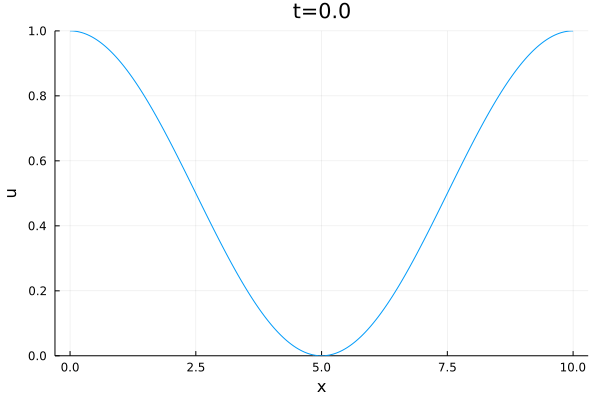

In [8]:
anim1 = Animation()
x = 0.0:Dx:Lx
if Nx%2==0
  cent_ind = Int(Nx/2+1)
else
  cent_ind = Int((Nx+1)/2+1)
end
ylim = 1.0
@inbounds @simd for loop = 0:timespan
  # 毎回出力するとデータが多すぎるので、skiptime ステップごとに出力する．
  if mod(loop, skiptime) == 0
    time = round(loop*Dt, digits=digits)
    u_data = deserialize(datapath*"/u/"*string(time)*".dat")
    up = u_data["u"][2:Nx+2]
  end
  # if mod(loop, skiptime) == 0
  if mod(loop, skiptime*2) == 0
    plt1 = plot(x, up, title="t="*string(time), ylims=(0.0, ylim), 
    xlabel="x", ylabel="u", label="")
    # savefig(datapath*"/fig/u_t="*string(time)*".png")
    frame(anim1, plt1)
  end
end

gif(anim1, datapath*"/anim/anim_u-"*string(tag)*".gif", fps = 30)